### Setting path and Importing packages

In [1]:
#set_path 

on_mac = True
on_thinkpad = False 
on_hpg = False

if on_mac == True: 
    data_path = "/Volumes/hodaakl/"
if on_thinkpad== True: 
    data_path = "//exasmb.rc.ufl.edu/blue/pdixit/hodaakl/"
if on_hpg == True: 
    data_path = "/blue/pdixit/hodaakl/"
    
proj_folder = data_path + 'A1MCMC_SEGFR_AKT/'


In [2]:
# load packages 
import csv
import numpy as np 
import random
import time
from scipy.integrate import solve_ivp
from collections import defaultdict
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import pandas as pd

### Initialize Lambda

In [8]:

outputfolder = proj_folder + 'Output/0901LocalRun_out1_posGrad/'

Constraint_mu_only = False 


if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)
else: 
    raise ValueError("folder already exists, can't initialize lambda")


    

file_name_lambda =outputfolder+ 'Lambdas.csv'

if Constraint_mu_only: 
    dim = 10
    Lambda_init = 0.001*np.random.rand(dim) 

else: 
    dim = 20
    Lambda_init = np.random.rand(dim)
    
    Lambda_init[:10] =Lambda_init[:10]*10**(-5)  ## This then is of order 10^-6
    Lambda_init[10:] =Lambda_init[10:]*10**(-10)  # I want this to be of order 10^-11



if os.path.exists(file_name_lambda): 
    print('file already exists')
    
else:
    
    with open(file_name_lambda, 'w') as new_file_lambda:
        csv_writer_lambda = csv.writer(new_file_lambda, delimiter = ',')
        csv_writer_lambda.writerow(Lambda_init)
        new_file_lambda.flush()

### MaxEnt functions

In [9]:


par_low_7 = np.load(data_path + 'Data/Low_Pars_NoDimerazationModel_0301.npy')
par_high_7  = np.load(data_path + 'Data/high_Pars_NoDimerazationModel_0309_ksynInc.npy')
L_arr  = np.load(data_path + 'Data/SingleCellData/EGFR_doses_10Conditions_20201116.npy' )
seg_bounds = np.load(data_path + 'Data/segfr_lims_10conds_0304.npy' ) ## the bounds are in units of a.u.





def segfr_preds(L, pars_arr,SF = 0.00122 ):# The SF is to change from a.u. to molecules based on 305 a.u. = 250*10^3 molecules  ):
    ## steady state predictions 
    ## # Pars array is of length 7 
    # pars = [ksyn, k1, kn1, kap, kdp, ki, kis]
    # idx = [16, 0, 1, 4, 5, 8, 9]
    [ksyn, k1, kn1, kap, kdp, ki, kis] = 10**pars_arr # parameters are in log scale!  
    ksyn = ksyn/SF
#     kap = kap/SF
    R0  = ksyn/ki
    mean= (ki* (kap* (kis+k1* L)+(kis+kdp) *(ki+kn1+k1* L))* R0)/(kap *kis* (ki+k1 *L)+ki *(kis+kdp) *(ki+kn1+k1*L))
    sec_mom = (ki*(kap *(kis+k1*L)+(kis+kdp)* (ki+kn1+k1*L)) *R0* (kap* kis* (ki+k1* L)+kap* ki* (kis+k1* L) *R0+ki* (kis+kdp)* (ki+kn1+k1* L)* (1+R0)))/(kap* kis* (ki+k1*L)+ki* (kis+kdp) *(ki+kn1+k1 *L))**2
    return mean, sec_mom


def model_preds(pars, Ligand_conc =L_arr ):
    """solves for all the ligand concentrations and returns the means and the second moments"""
    n = len(Ligand_conc)
    sol_arr = np.zeros(2*n)
    for i in range(n): 
        L = Ligand_conc[i]
        mu, s = segfr_preds(L = L , pars_arr = pars,SF = 0.00122 )
        sol_arr[i] = mu
        sol_arr[i+n] = s
    return sol_arr



def calculate_energy(vec, Lagrange_mul):
    "vec is of length 20, with the first 10 being the mean and the second 10 being 2nd moment for specific condition"
    energy = np.dot(vec, Lagrange_mul) 
    return energy 

## get new parameters 
def new_pars_v3(pars_old,  upperbound = par_high_7 , lowerbound = par_low_7, beta =.05 ):
    """Returns new parameters """
    # pars_old is of length 7 
    # nchange is the number of parameters that will be updates (chosen at random)
    nchange = np.random.randint(1,5)    
    delta = .5*abs(upperbound - lowerbound )
    npoints = len(pars_old)
    
    idx = random.sample(range(0,npoints),nchange)
    
    newpars = pars_old.copy()
    
    newpars[idx] = newpars[idx] + beta*(2*np.random.rand(nchange)-1)*delta[idx]
    return newpars


## parameter cutoff

def pars_w_cutoff(pars, upperbound = par_high_7, lowerbound = par_low_7):
    ## modified from before because here, we don't have k2 and kn2
#     pars = [ksyn, k1, kn1, kap, kdp, ki, kis]
    Flag_bounds = 1  #assume that it is within bounds and check if that is false then change to 0. 
    Flag_range  = 0  # assume that it is out of range and check if in range change to 1. 
    
    idx1 = np.where(pars>upperbound)
    idx2 = np.where(pars<lowerbound)
    
    Kd1 = 10**(pars[2]-pars[1]);  # kn1 - k1
    
    if len(idx1[0])>0 or len(idx2[0])>0:
        Flag_bounds = 0
    if Kd1>5 and Kd1<80:
        Flag_range = 1
        
    return Flag_bounds, Flag_range


def abund_w_cutoff(model_preds_arr , bounds = seg_bounds,  SF = 0.00122 ):
#      """ decides whether the solution is within the biological limits from the data Input: model_preds_arr : solution of SEGFR for the 10 concentrations means and 2nd moments (so of len 20)"""
# here we don't use background 
    if len(model_preds_arr)>10: 
        model_preds_mu_arr = model_preds_arr[:10]
        
    
    bounds = bounds/SF
    ## Also scaled the bounds with SF
    
    if (len(np.where(model_preds_mu_arr>bounds[:,1])[0])>0)  or (len(np.where(model_preds_mu_arr<bounds[:,0])[0])>0) :
        abund_bound_flg = 0

    else :
        abund_bound_flg = 1
        

         ## check if EGFR levels with time. 
       #ignore background for now 
    flEGFR_rat = ( model_preds_mu_arr[-1])/( model_preds_mu_arr[1] )
    

    if  flEGFR_rat < 1:
        fl_egfr = 1 
    else : 
        fl_egfr = 0
    
    
    return abund_bound_flg, fl_egfr


# In[8]:


def RunSimulation_v3(Lambda,iteration, Nmc, ignore_steps =0, save_every_nsteps = 1):
    print(f' starting chain for iteration {iteration} ' )
    filename_abund = outputfolder + f'SS_data_{iteration}.csv'
    filename_pars  = outputfolder + f'Pars_{iteration}.csv'
    filename_a_ratio = outputfolder + f'a_ratio.csv'
    filename_a_lists = outputfolder + f'a_lists.csv'

    #     Nmc = 4

  # idx = [16, 0, 1, 4, 5, 8, 9]
    par_low_7 = np.load(data_path + 'Data/Low_Pars_NoDimerazationModel_0301.npy')
    par_high_7  = np.load(data_path + 'Data/high_Pars_NoDimerazationModel_0309_ksynInc.npy')
    L_arr  = np.load(data_path + 'Data/SingleCellData/EGFR_doses_10Conditions_20201116.npy' )
    seg_bounds = np.load(data_path + 'Data/segfr_lims_10conds_0304.npy' ) ## the bounds are in units of a.u.

    time0 = time.time()

    SaveStep = save_every_nsteps
    
    ss = 0 #to count for ignore steps 
    
    
    a_list = []
###################### GETTING THE INITIAL POINT ####################################################################
    if iteration == 0: 
#         K_curr =  np.random.uniform(low = par_low/2 , high = par_high/2) # current parameters
        K_curr = .5*(par_high_7 + par_low_7 ) 

    else: 
        print('picking the parameters from last iteration')
        # Load the parameters dataset from the previous iteration
        par_path =  outputfolder + f'Pars_{iteration-1}.csv'
        par_df = pd.read_csv(par_path, header=None)
        par_np_all = par_df.to_numpy()
        ## Get the indices that are nan 
        idxn = np.argwhere(np.isnan(par_np_all))
        idx_nan_rows = idxn[:,0] # get the rows that have nan
        par_np = np.delete(par_np_all,idx_nan_rows, 0)
        maxidx   = par_np.shape[0]
        pickidx  = random.randrange(0,maxidx)
        K_curr   = par_np[pickidx,:]    # 
  
    abund_curr = model_preds(pars=K_curr)
    
    fl_bound_par, fl_range_par = pars_w_cutoff(K_curr, upperbound = par_high_7, lowerbound=par_low_7)
    fl_abound_abund, fl_range_s = abund_w_cutoff(model_preds_arr = abund_curr)
    
    fl = fl_bound_par*fl_range_par*fl_abound_abund*fl_range_s
    
    # print('for initial point flag =', fl)
    loop_steps = 0
    while fl == 0: 
        loop_steps+=1
        K_curr = new_pars_v3(pars_old=K_curr, lowerbound= par_low_7, upperbound= par_high_7)
        fl_bound_par, fl_range_par = pars_w_cutoff(K_curr, upperbound = par_high_7, lowerbound=par_low_7)
#         print('for pars -> (fl_bound, fl_range ) = ', fl_bound_par, fl_range_par)
        if (fl_bound_par==1) and (fl_range_par ==1): 
            abund_curr = model_preds(K_curr)
            fl_abound_abund,  fl_range_s = abund_w_cutoff(model_preds_arr = abund_curr)
#             print('for abund -> (fl_bound, fl_range ) = ', fl_abound_abund, fl_range_s)
#             print('found good point SHOULD STOP')
                
        fl = fl_bound_par*fl_range_par*fl_abound_abund*fl_range_s
#         print(fl)
    
    print('took ', loop_steps, ' steps to find good parameters')        
    
    
    E_curr = 1000
    a = 0 # for acceptance probility
    
    for i in range(Nmc): 

        if i==0: 
            t00 = time.time()
        K_new = new_pars_v3(pars_old = K_curr,  upperbound = par_high_7 , lowerbound = par_low_7, beta = .5 )
        
        flag_bounds, flag_range = pars_w_cutoff(K_new, upperbound = par_high_7, lowerbound=par_low_7)
        
#         if flag_bounds ==0 or flag_range ==0 :
#             k_bad.append(K_new)
            
        par_flg = flag_bounds*flag_range

        
        
        if par_flg ==1:
            # print('parameters are within cutoffs ')
            abund_new = model_preds(K_new)
            
            flag_abund, segfr_flg = abund_w_cutoff(model_preds_arr = abund_new)
            
            a_flg = flag_abund*segfr_flg
            
            if a_flg ==1: 
                # print('Abund w/ cutoff')
                E_new  = calculate_energy(vec =abund_new ,Lagrange_mul = Lambda)
                # print('E_new', E_new)

                deltaE = E_new - E_curr 
                deltaE = np.array([deltaE], dtype = np.float128)
                
                prob = np.exp(-deltaE)[0]
#                 print('exp(-delta E) = ', round(prob,2))
                
                
                A = min(1,prob)
                a_list.append(A)
                
#                 print('A',A)
                

                if random.random() < A : #With probability A do x[i+1] = x_proposed
                    a = a+1 
                    K_curr = K_new.copy()
                    abund_curr = abund_new.copy()
                    E_curr = E_new.copy()
                
        if i%SaveStep ==0 :
            ss = ss+1 
            if ss > ignore_steps:
        # writing the single cell abundances 
                if os.path.exists(filename_abund): 
                    with open(filename_abund, 'a') as add_file:
                        csv_adder = csv.writer(add_file, delimiter = ',')
                        csv_adder.writerow(abund_curr)
                        add_file.flush()
                else:
                    with open(filename_abund, 'w') as new_file:

                        csv_writer = csv.writer(new_file, delimiter = ',')
                        # csv_writer.writerow(fieldnames)
                        csv_writer.writerow(abund_curr)
                        new_file.flush()
#          writing the parameters
                if os.path.exists(filename_pars): 
                    with open(filename_pars, 'a') as add_file_pars:
                        csv_adder_pars = csv.writer(add_file_pars, delimiter = ',')
                        csv_adder_pars.writerow(K_curr)
                        add_file_pars.flush()
                else:
                    with open(filename_pars, 'w') as new_file_pars:

                        csv_writer_pars = csv.writer(new_file_pars, delimiter = ',')
                        csv_writer_pars.writerow(K_curr)
                        new_file_pars.flush()

    
        if i==0: 
            t11 = time.time()
            print()
    A_Ratio = a/Nmc
    print(f'Acceptance ratio ={ A_Ratio}')
    time3 = time.time()
    print('time for one step = '+ str((time3 - time0)/Nmc))

    # writing the acceptance ration 

    if os.path.exists(filename_a_ratio): 
        with open(filename_a_ratio, 'a') as add_file_a:
            csv_adder_a = csv.writer(add_file_a, delimiter = ',')
            csv_adder_a.writerow([iteration, A_Ratio])
            add_file_a.flush()
    else:
        with open(filename_a_ratio, 'w') as new_file_a:

            csv_writer_a = csv.writer(new_file_a, delimiter = ',')
            csv_writer_a.writerow([iteration, A_Ratio])
            new_file_a.flush()
            
    if os.path.exists(filename_a_lists): 
        with open(filename_a_lists, 'a') as add_file_a_list:
            csv_adder_a_list = csv.writer(add_file_a_list, delimiter = ',')
            csv_adder_a_list.writerow([iteration, a_list])
            add_file_a_list.flush()
    else:
        with open(filename_a_lists, 'w') as new_file_a_lists:

            csv_writer_a_lists = csv.writer(new_file_a_lists, delimiter = ',')
            csv_writer_a_lists.writerow([iteration, a_list])
            new_file_a_lists.flush()
  
 #    print()
    return 




### Running MaxEnt

In [10]:
## ## Updating Lambda
Constraint_mu_only = False 
SF = 0.00122 
ModelScaleFactor = SF  #this will be our scale factor
# 
mu_arr = np.load(data_path + 'Data/SingleCellData/EGFR_mean_10Conditions_20201116.npy')
s_arr  = np.load(data_path + 'Data/SingleCellData/EGFR_2ndMomentMean_10Conditions_20201116.npy' )
# L_arr  = np.load('/blue/pdixit/hodaakl/Data/SingleCellData/EGFR_doses_10Conditions_20201116.npy')

dim = 10 ## we got 10 dimensions 

Constraints = np.concatenate((mu_arr, s_arr), axis=0)

# to convert to a.u. to molecules
Constraints[:dim] = Constraints[:dim]/ModelScaleFactor
Constraints[dim:] = Constraints[dim:]/(ModelScaleFactor**2)



if Constraint_mu_only: 
    Constraints = Constraints[:dim]





def calculate_constraints(data, cons_mu_only = Constraint_mu_only ):
    """ inputs (data) with shape = (ncells, nConditions) : ncells would represent the number of MCMC samples taken"""
#     print('shape pf data ', data.shape)
    preds = np.mean(data, axis = 0 ) # means along the column, to get the mean over all the cells
    return preds 
# 
# 


def update_lambda(Error, old_lambda, alpha = 10**(-7), true_data = Constraints, gradient_sign = 1 ):
    # alpha_array = alpha*np.ones(24)
    if len(Error) == dim: 
        alpha_arr = alpha*np.ones(dim)
    else: 
        alpha_arr = alpha*np.ones(2*dim)
        alpha_arr[dim:] = alpha_arr[dim:]*10**(-5)
    # Lambda = old_lambda.copy() + alpha*(Error)
    Lambda = old_lambda.copy() + gradient_sign*alpha_arr*(Error)/true_data
    return Lambda


def openfile(filename):
    with open(filename,'r') as csvfile:
        reader = csv.reader(csvfile)
        rows= [col for col in reader]
    rows=np.array(rows)
    rows=rows.astype(np.float128)
    return rows


# In[62]:


file_name_lambda =outputfolder+ 'Lambdas.csv'

Nmc = 100000
ig_steps = 100
save_ev = 50

if os.path.exists(file_name_lambda): 
    df_lambdas = pd.read_csv(file_name_lambda, sep = ',', header = None) 
    data_lambdas = df_lambdas.to_numpy()
    iteration, _ = data_lambdas.shape
    iteration = iteration -1
    Lambda = data_lambdas[-1,:]
else:
    print('lambda file doesnt exist')


# In[63]:


n_iterations = 30
for i in range(n_iterations): 
    if os.path.exists(file_name_lambda): 
        df_lambdas = pd.read_csv(file_name_lambda, sep = ',', header = None) 
        data_lambdas = df_lambdas.to_numpy()
        iteration, _ = data_lambdas.shape
        iteration = iteration -1
        Lambda = data_lambdas[-1,:]
    else:
        print('lambda file doesnt exist, need to initialize')
    
    RunSimulation_v3(Lambda, iteration= iteration ,Nmc=Nmc,ignore_steps=ig_steps, save_every_nsteps= save_ev )
    
    ## update lambda 
    Lambda_np = openfile(file_name_lambda)


    filename_abund = outputfolder + f'SS_data_{iteration}.csv'
    df = pd.read_csv(filename_abund, sep = ',', header = None) 
    Data_np = df.to_numpy()
    ### take away the nan values 
    idxn = np.argwhere(np.isnan(Data_np))
    idx_nan_rows = idxn[:,0]

    data = np.delete(Data_np,idx_nan_rows, 0)



    # data = openfile(filename_abund)

#     print(data.shape)
#     preds = calculate_constraints(data)
#     print(preds.shape)


    # Constraints = Constraints[:24]
    Preds = calculate_constraints(data)
    # Preds = np.append(mu_sim, s_sim)
    Error = Preds - Constraints 
    print('avg abs error of iteration ' + str(iteration) + '=' + str(round(np.mean(abs(Error)),3)))
    # rel_err = Error/Constraints
    file_name_error = outputfolder+ 'Errors.csv'
    # file_name_avg_abs_error =outputfolder+ 'Avg_abs_error.csv'

    Old_Lambda = Lambda_np[-1,:]
    # avgabserr = np.mean(abs(Error))
    Lambda = update_lambda(Error = Error, old_lambda= Old_Lambda, gradient_sign=1) 
    Lambda= Lambda.tolist()
    Error = Error.tolist()



    #################################################### Storing the error 
    if os.path.exists(file_name_error): 
        with open(file_name_error, 'a') as add_file_error:
            csv_adder_error = csv.writer(add_file_error, delimiter = ',')
            csv_adder_error.writerow(Error)
            add_file_error.flush()
    else:
        with open(file_name_error, 'w') as new_file_error:

            csv_writer_error = csv.writer(new_file_error, delimiter = ',')
    #         csv_writer_pars.writerow(Par_fieldnames)
            csv_writer_error.writerow(Error)
            new_file_error.flush()

    #################################################### Storing the Lambda  

    if os.path.exists(file_name_lambda): 
        with open(file_name_lambda, 'a') as add_file_lambda:
            csv_adder_lambda = csv.writer(add_file_lambda, delimiter = ',')
            csv_adder_lambda.writerow(Lambda)
            add_file_lambda.flush()
    else:
        print('trouble loading file')
        
    print()
    print()

 starting chain for iteration 0 
took  0  steps to find good parameters

Acceptance ratio =0.27779
time for one step = 0.007279764931201935
avg abs error of iteration 0=12972117461.929


 starting chain for iteration 1 
picking the parameters from last iteration
took  0  steps to find good parameters



KeyboardInterrupt: 

### Assess the output

In [6]:

# outputfolder = '/blue/pdixit/hodaakl/A1Max_Ent_Parameter_Inference/Output/Grad_Neg/'

err_fn = outputfolder +  'Errors.csv'
lambda_fn = outputfolder + 'Lambdas.csv'
acc_fn = outputfolder + 'AccRatio.csv'
df = pd.read_csv(err_fn, sep = ',', header = None) 
err_np = df.to_numpy()
df_l = pd.read_csv(lambda_fn, sep = ',', header = None)
# df_acc  = pd.read_csv(acc_fn, sep = ',', header = None)
# acc_np = df_acc.to_numpy()
lambda_np = df_l.to_numpy()


print(err_np.shape)
print(lambda_np.shape)

(30, 20)
(31, 20)


Text(0.5, 0, 'Iteration')

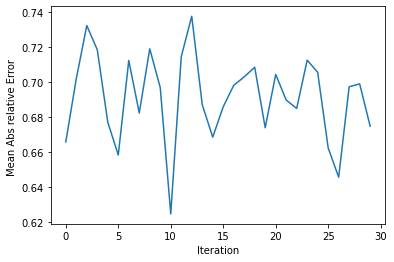

In [7]:

rc_m= np.tile(Constraints , [err_np.shape[0],1])

real_abs = abs(err_np/rc_m)
mean_rel_abs = np.mean(real_abs, axis = 1)
# mean_err = np.mean(abs(err_np), axis = 1)
plt.plot(mean_rel_abs)
plt.ylabel('Mean Abs relative Error ')
plt.xlabel('Iteration')
# plt.title('Iteration[1:]')